In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.applications import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if physical_devices != []:
    print("Using GPU")
    for i in physical_devices:
        tf.config.experimental.set_memory_growth(i, True)
else:
    print("Using CPU")
    pass

Using GPU


# Model Architectures

## classical_cnn

In [3]:
def classical_cnn(dim, output_neurons, output_activation):
    print("\nTRAINING ON classical_cnn MODEL:-")
    
    
    def block(tensor, conv_reps, n_filters):
        x = Conv2D(filters = n_filters, kernel_size = (3,3), padding = 'same')(tensor)
        x = LeakyReLU()(x)
        
        for i in range(conv_reps-1):
            x = Conv2D(filters = n_filters, kernel_size = (3,3), padding = 'same')(x)
            x = LeakyReLU()(x)
            
        x = MaxPooling2D(pool_size = (2,2), strides = 2, padding = 'same')(x)
        
        return x

    input = Input(shape = dim)
        
    k = 8
    x = block(input, conv_reps = 1, n_filters = k)
    x = block(x, conv_reps = 1, n_filters = 2*k)
    x = block(x, conv_reps = 1, n_filters = 4*k)
    x = block(x, conv_reps = 1, n_filters = 8*k)
    x = block(x, conv_reps = 1, n_filters = 16*k)
    
    x = Flatten()(x)
    
    dense_reps = 2
    
    for i in range(dense_reps):
        x = Dense(128)(x)
        x = LeakyReLU()(x)
    
    output = Dense(output_neurons, output_activation)(x)  
    
    model = Model(inputs = input, outputs = output)
    
    return model

## pooled_mobile

In [4]:
def pooled_mobile(dim, output_neurons, output_activation):
    print("\nTRAINING ON pooled_mobile MODEL:-")

    
    def block(x, n_filters, d_strides):
        # depthwise
        x = DepthwiseConv2D(kernel_size = (3,3), strides = d_strides, padding = 'same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
    
        # pointwise
        x = Conv2D(filters = n_filters, kernel_size = (1,1))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        
        # max-pool
        x = MaxPooling2D(pool_size = (2,2), strides = 2, padding = 'same')(x)
    
        return x
    
    
    input = Input(shape = dim)
    
    k = 16
    x = Conv2D(filters = k, kernel_size = (3,3), strides = 2, padding = 'same')(input)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = block(x, n_filters = 2*k, d_strides = 1)
    x = Dropout(0.2)(x)

    x = block(x, n_filters = 4*k, d_strides = 1)    
    x = Dropout(0.2)(x)

    x = block(x, n_filters = 8*k, d_strides = 1)    
    x = Dropout(0.2)(x)

    x = block(x, n_filters = 16*k, d_strides = 1)
    x = Dropout(0.3)(x)

    x = block(x, n_filters = 32*k, d_strides = 1)
    x = Dropout(0.3)(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    
    output = Dense(output_neurons, output_activation)(x)  
    
    model = Model(inputs = input, outputs = output)
    
    return model

## mobile_inception

In [5]:
def mobile_inception(dim, output_neurons, output_activation):
    print("\nTRAINING ON mobile_inception MODEL:-")

    
    def block(x, filters, reps):
        for _ in range(reps):
            # for low-level features
            t1 = Conv2D(filters[0], kernel_size = (1,1))(x)
            t1 = LeakyReLU()(t1)

            # for mid-level features
            t2 = DepthwiseConv2D(kernel_size = (3,3), strides = 1, padding = 'same')(x)
            t2 = LeakyReLU()(t2)
            t2 = Conv2D(filters[1], kernel_size = (1,1))(t2)
            t2 = LeakyReLU()(t2)

            # for high-level features
            t3 = DepthwiseConv2D(kernel_size = (5,5), strides = 1, padding = 'same')(x)
            t3 = LeakyReLU()(t3)
            t3 = Conv2D(filters[2], kernel_size = (1,1))(t3)
            t3 = LeakyReLU()(t3)

            # for most-significant features
            t4 = MaxPool2D(pool_size = (3,3), strides = 1, padding = 'same')(x)
            t4 = Conv2D(filters[3], kernel_size = (1,1))(t4)
            t4 = LeakyReLU()(t4)

            x = Concatenate()([t1, t2, t3, t4])
        
        return x
        
        
    input = Input(shape = dim)
    
    k = 8
    
    x = Conv2D(filters = k, kernel_size = (7,7), strides = 2, padding = 'same')(input)
    x = LeakyReLU()(x)
    x = MaxPool2D(pool_size = (3,3), strides = 2, padding = 'same')(x)
    
    x = DepthwiseConv2D(kernel_size = (3,3), strides = 1, padding = 'same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(filters = 2*k, kernel_size = (1,1))(x)
    x = LeakyReLU()(x)
    x = MaxPool2D(pool_size = (2,2), strides = 2)(x)
    
    x = block(x, [k, k, k, k], reps = 2)
    x = MaxPool2D(pool_size = (2,2), strides = 2)(x)
    
    x = block(x, [2*k, 2*k, 2*k, 2*k], reps = 2)
    x = MaxPool2D(pool_size = (2,2), strides = 2)(x)

    x = block(x, [4*k, 4*k, 4*k, 4*k], reps = 2)
     
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    
    output = Dense(output_neurons, output_activation)(x)
    
    model = Model(inputs = input, outputs = output)    
    
    return model

## mobile_dense

In [6]:
def mobile_dense(dim, output_neurons, output_activation):
    print("\nTRAINING ON mobile_dense MODEL:-")
    
    
    def conv_leakyrelu(x, filters, kernel_size):
        # depthwise
        x = DepthwiseConv2D(kernel_size = (3,3), strides = 1, padding = 'same')(x)
        x = LeakyReLU()(x)
    
        # pointwise
        x = Conv2D(filters = filters, kernel_size = (1,1))(x)
        x = LeakyReLU()(x)        
        
        return x
    
    
    def dense_block(tensor, k, reps):
        for _ in range(reps):
            x = conv_leakyrelu(tensor, filters=4*k, kernel_size=1)
            x = conv_leakyrelu(x, filters=k, kernel_size=3)
            tensor = Concatenate()([tensor, x])
        
        return tensor
    
    
    def transition_layer(x, theta):
        f = int(tf.keras.backend.int_shape(x)[-1]*theta)
        x = conv_leakyrelu(x, filters=f, kernel_size=1)
        x = AvgPool2D(pool_size=2, strides=2, padding='same')(x)
        return x 
    
    
    k = 8
    theta = 0.5
    repetitions = 5, 10, 15, 20

    input = Input(shape=dim)

    x = Conv2D(k, 7, strides=2, padding='same')(input)
    x = LeakyReLU()(x)
    x = MaxPool2D(3, strides=2, padding='same')(x)

    for reps in repetitions:
        d = dense_block(x, k, reps)
        x = transition_layer(d,theta)

    x = GlobalAvgPool2D()(d)

    output = Dense(output_neurons, output_activation)(x)  

    model = Model(inputs = input, outputs = output)

    return model

# Choose Model Architecture

In [7]:
h = int(input("Image Dimension(H or W): "))
w = h
dim = (h,w,3)

Image Dimension(H or W): 128


In [8]:
output_neurons = int(input("Number of classes: "))

if output_neurons > 1:
    output_activation = 'softmax'
else:
    output_activation = 'sigmoid'

Number of classes: 3


In [9]:
print("Press 1 for classical_cnn")
print("Press 2 for pooled_mobile")
print("Press 3 for mobile_inception")
print("Press 4 for mobile_dense")


model_select = int(input("\nChoose model: "))

if model_select == 1:
    model = classical_cnn(dim, output_neurons, output_activation)
if model_select == 2:
    model = pooled_mobile(dim, output_neurons, output_activation)
if model_select == 3:
    model = mobile_inception(dim, output_neurons, output_activation)
if model_select == 4:
    model = mobile_dense(dim, output_neurons, output_activation)

Press 1 for classical_cnn
Press 2 for pooled_mobile
Press 3 for mobile_inception
Press 4 for mobile_dense

Choose model: 2

TRAINING ON pooled_mobile MODEL:-


# Summary

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 16)        64        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 16)        0         
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 64, 64, 16)        160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 16)        64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 16)        0     

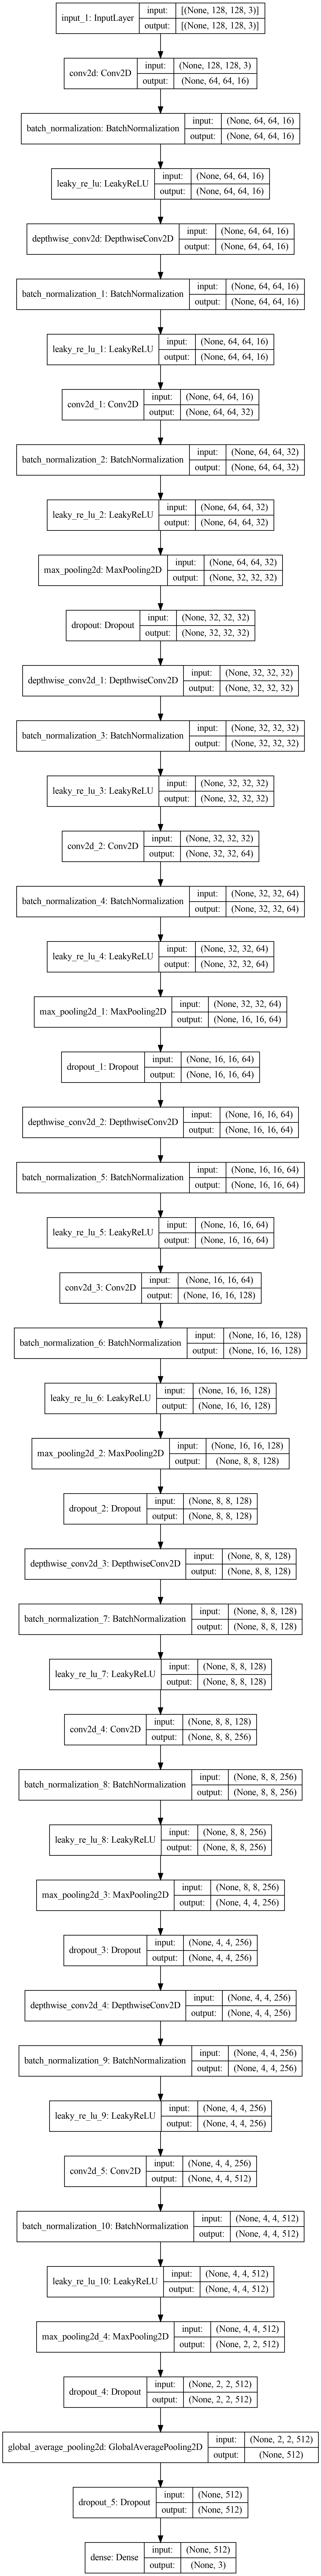

In [11]:
plot_model(
    model,
#     to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB", # TB -> Vertical; LR -> Horizontal
    expand_nested=False,
    dpi=300,
)